In [1]:
import os
import random

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

In [2]:
def forward_process(img_t_minus_1, beta, t):
    """Implements the forward process of a DDPM model.

    Args:
        img_t_minus_1: Image at the previous timestep (t - 1)
        beta: Scheduled Variance
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """

    beta_t = beta[t].reshape(-1, 1, 1)
    mu = torch.sqrt(1.0 - beta_t) * img_t_minus_1
    sigma = torch.sqrt(beta_t)
    img_t = mu + sigma * torch.randn_like(img_t_minus_1)
    return img_t


def forward_process_ddpms_reparm(orig_img, alpha_bar, t):
    """Implements the efficient forward process of a DDPM model.

    Args:
        orig_img: Image at timestep t=0
        alpha_bar: The reparameterized version of beta
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    noise = torch.randn_like(orig_img)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1)
    mu = torch.sqrt(alpha_bar_t) * orig_img
    sigma = torch.sqrt(1.0 - alpha_bar_t)
    img_t = mu + sigma * noise
    return img_t, noise


In [3]:
def gen_alpha_bar(beta):
    alpha = 1.0 - beta
    alpha_bar = torch.cumprod(alpha, dim=0)
    return alpha_bar


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps, dtype=torch.float32)


def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float32)
    alpha_bar = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alpha_bar = alpha_bar / alpha_bar[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)


In [4]:
def run_foward_process(img, timesteps, samples, beta) -> list[Image.Image]:
    processed_images = [img]  # Image at 0th step
    img_t = transforms.ToTensor()(img).float()

    # 5. Run the forward process to obtain img after t timesteps
    samples = set(range(int(timesteps/samples), timesteps, int(timesteps/samples)))
    for t in range(timesteps):
        img_t = forward_process(img_t_minus_1=img_t, beta=beta, t=t)
        if t in samples or t == timesteps-1:
            sample = transforms.ToPILImage()(torch.clamp(img_t, 0, 1))
            processed_images.append(sample)
    return processed_images


def run_reparm_foward_process(img, timesteps, samples, alpha_bar) -> list[Image.Image]:
    processed_images = [img]  # Image at 0th step
    orig_img = transforms.ToTensor()(img).float()

    # 2. Run the forward pass for specific timesteps
    # We will use the timesteps we used in previous visualizations
    for step in range(int(timesteps/samples), timesteps+1, int(timesteps/samples)):
        step -= 1
        img_t, noise = forward_process_ddpms_reparm(orig_img, alpha_bar, step)
        img_t = transforms.ToPILImage()(torch.clamp(img_t, 0, 1))
        processed_images.append(img_t)
    return processed_images


def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


def sample_reparm_foward_process(img_x_0, step, alpha_bar, device="cpu"):
    img_t, noise = forward_process_ddpms_reparm(img_x_0, alpha_bar, step)
    return img_t.to(device), noise.to(device)


In [5]:
# 3. Plot and see samples at different timesteps
def plot_processed_images(processed_images: list, timesteps: int, samples: int, aux: str = ""):
    fig, ax = plt.subplots(1, len(processed_images), figsize=(15, 6))

    for i, sample in enumerate(processed_images):
        ax[i].imshow(sample)
        ax[i].set_title(f"t: {int(i*timesteps/samples)}")
        ax[i].axis("off")
        ax[i].grid(False)

    fig.suptitle(f"{aux}Forward process in DDPMs", y=0.70)
    fig.savefig(f"output/{aux.lower().replace(' ', '_')}_forward_process.png",
                pad_inches=0,
                bbox_inches='tight'
                )

def get_random_file(directory):
    files = os.listdir(directory)
    random_file = random.choice(files)
    return os.path.join(directory, random_file)

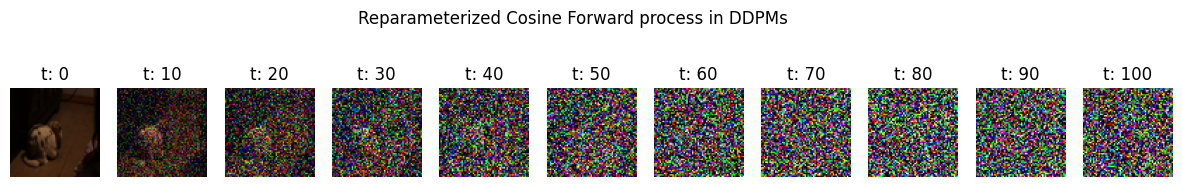

In [7]:
# 1. Load image using PIL (or any other library that you prefer)
img = Image.open(get_random_file('bunnyset'))

# 2. Resize the image to desired dimensions
img_size = (64, 64)
img = img.resize(size=img_size)

# 3. Define number of timesteps
timesteps = 100
samples = 10

# 4. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05

# Linear schedule
# beta_lin = linear_beta_schedule(timesteps, beta_start, beta_end)
# Cosine schedule
beta_cos = cosine_beta_schedule(timesteps)

foward_reparm_processed_lin = run_reparm_foward_process(img, timesteps, samples, gen_alpha_bar(beta_lin))
foward_reparm_processed_cos = run_reparm_foward_process(img, timesteps, samples, gen_alpha_bar(beta_cos))
foward_processed_cos = run_foward_process(img, timesteps, samples, beta_cos)

plot_processed_images(foward_reparm_processed_lin, timesteps, samples, "Reparameterized Linear ")
plot_processed_images(foward_reparm_processed_cos, timesteps, samples, "Reparameterized Cosine ")
plot_processed_images(foward_processed_cos, timesteps, samples, "Default Cosine ")